<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Example:-Examine-Potentials" data-toc-modified-id="Example:-Examine-Potentials-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Example: Examine Potentials</a></span></li><li><span><a href="#Example:-Manually-Examining-Simulation-Information" data-toc-modified-id="Example:-Manually-Examining-Simulation-Information-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Example: Manually Examining Simulation Information</a></span></li><li><span><a href="#Example:-Automatically-Creating-a-Simulation-Script" data-toc-modified-id="Example:-Automatically-Creating-a-Simulation-Script-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Example: Automatically Creating a Simulation Script</a></span></li></ul></div>

In [1]:
import numpy as np
import utils
import matplotlib.pyplot as plt
%matplotlib inline

# Example: Examine Potentials

In [2]:
from utils import LAMMPS

In [3]:
r_, u_, f_ = LAMMPS.force_shifted_lennard_jones(
    r_min=0.7, r_cut=2.5, eps=1.0, sigma=1.0, alpha=6, bins=1000)

(-3.5, 3.5)

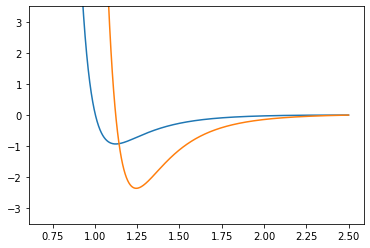

In [4]:
plt.plot(r_, u_, color='C0')
plt.plot(r_, f_, color='C1')
plt.ylim(-3.5, 3.5)

In [5]:
r_, u_, f_ = LAMMPS.force_shifted_yukawa(
    r_min=0, r_cut=2.5, eps=1.0, kappa=5.0, bins=1000)

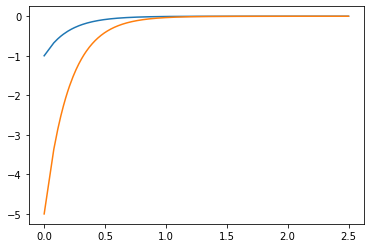

In [6]:
plt.plot(r_, u_, color='C0')
plt.plot(r_, f_, color='C1')

In [7]:
sig = 1.0
kappa_sig = 2.5
r_, u_, f_ = LAMMPS.force_shifted_tanh(
    
    r_min=0, r_cut=2.5*sig, eps=-1.0, sigma=sig, kappa=kappa_sig/sig, bins=1000)

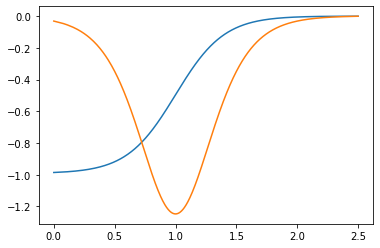

In [8]:
plt.plot(r_, u_, color='C0')
plt.plot(r_, f_, color='C1')

# Example: Manually Examining Simulation Information

In [9]:
# Step 1: Load Colloid from C++ code
from utils import Colloid

c = Colloid()
c.load(
    filename='../examples/initialize_colloid/colloid.json'
)

# Scale so motif points are "at contact" - also sets "diameters"
# of the beads when using inplace=True
scale_constant = c.scale(inplace=True) 

# Always save the Colloid object so you have the mapping of types
c.save('colloid.pkl')

In [10]:
# Step 2a: Create a mixture of a set of different enantiomorphs
from utils import LAMMPS

buffer = 1.0 # Gap around colloids
box = [30, 30] # Box widths
n_each = [8, 8] # Number of each chirality [same, opposite]

coords_, types_, bbox_ = LAMMPS.tile(c, box, buffer, n=n_each)

In [11]:
# For rigid bodies, LAMMPS needs to know how "big" the rigid body is
# See: https://docs.lammps.org/fix_rigid.html (using rigid/npt/small)
# The comm_modify command will be used to make sure the cutoff is
# at least the "diameter" of the particle to ensure this works
# correctly.
# pseudo_diameter = np.sqrt(np.sum((bbox_[:,1] - bbox_[:,0])**2))

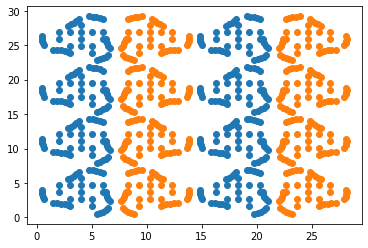

In [12]:
# Step 2b: Let's color by chirality
from utils import Analysis

l = len(c.coords)
end = l
while end <= len(coords_):
    x = Analysis.identify_chirality(
        Analysis.unwrap(c.coords, box), 
        Analysis.unwrap(coords_[end-l:end], box)
    )

    plt.plot(coords_[end-l:end,0], coords_[end-l:end,1], 'o', color='C{}'.format(int(not x)))
    end += l

# Example: Automatically Creating a Simulation Script

In [13]:
# Step 3: Turn that into a LAMMPS file to read
init_config_filename = 'init_config.lammps'
_ = LAMMPS.create_initial_configuration(
    c, 
    box, 
    buffer, 
    n_each, 
    init_config_filename
)

In [14]:
# Step 4: Record the potential for each pair of particles
bins = 1000
potential_filename = 'potentials.table'
max_rcut = LAMMPS.tabulate_potentials(
    c,
    filename=potential_filename, 
    alpha=6, 
    kappa_sigma=2.5,
    bins=bins,
    style='fstanh'
)

pseudo_diameter = LAMMPS.rigid_body_min_comm(c, box, eps=0.1) + max_rcut

In [15]:
import re
def make(
    colloid, 
    output_filename,
    template_filename, 
    init_config_filename,
    potential_filename,
    bins,
    pseudo_diameter,
    steps_per_loop=50000,
    n_init_loops=10,
    n_equil_loops=100,
    n_prod_loops=1000,
    rec_freq=10000,
    res_freq=10000,
    Tstart=3.0,
    Tfinal=0.5,
    Pstart=0.1,
    Pfinal=0.1,
    dt=0.005,
):
    raw = open(template_filename, 'r').read()
    data = re.sub('__INIT_CONFIG__', str(init_config_filename), raw)
    data = re.sub('__REC_FREQ__', str(rec_freq), data)
    data = re.sub('__RES_FREQ__', str(res_freq), data)
    data = re.sub('__TSTART__', str(Tstart), data)
    data = re.sub('__TFINAL__', str(Tfinal), data)
    data = re.sub('__TDAMP__', str(100*dt), data) # See lammps.org/fix_nh.html
    data = re.sub('__PSTART__', str(Pstart), data)
    data = re.sub('__PFINAL__', str(Pfinal), data)
    data = re.sub('__PDAMP__', str(1000*dt), data) # See lammps.org/fix_nh.html
    data = re.sub('__TIMESTEP__', str(dt), data)
    data = re.sub('__TABLE_BINS__', str(int(bins)), data)
    data = re.sub('__PSEUDODIAMETER__', str(pseudo_diameter), data)
    data = re.sub('__STEPS_PER_LOOP__', str(int(steps_per_loop)), data)
    data = re.sub('__N_INIT_LOOPS__', str(int(n_init_loops)), data)
    data = re.sub('__N_EQUIL_LOOPS__', str(int(n_equil_loops)), data)
    data = re.sub('__N_PROD_LOOPS__', str(int(n_prod_loops)), data)

    n_atom_types = len(colloid.forward)
    
    command = ""
    for i in range(1, n_atom_types + 1):
        for j in range(i, n_atom_types + 1):
            command += "pair_coeff\t{} {} {} {}_{}\n".format(
                i, 
                j, 
                potential_filename, 
                i, 
                j
            )
    data = re.sub('__PAIR_COEFF__', command, data)
    
    command = ""
    for i in range(1, n_atom_types + 1):
        for j in range(i, n_atom_types + 1):
            command += "pair_write\t{} {} {} R {} {} potentials.interpolated {}_{}\n".format(
                i, 
                j, 
                int(bins), 
                1.0e-6, 
                pseudo_diameter,
                i,
                j
            )
    data = re.sub('__PAIR_WRITE__', command, data)

    open(output_filename, 'w').write(data)

In [16]:
make(
    colloid=c,
    output_filename='input.lmp',
    template_filename='npt.template', 
    potential_filename=potential_filename,
    init_config_filename=init_config_filename,
    bins=bins,
    pseudo_diameter=pseudo_diameter
)